In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/iLovePDF/dataset', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
data_dir = "Combined Dataset"
print(os.listdir(data_dir))

['train', 'test']


In [ ]:
data_dir += "/train"
print(os.listdir(data_dir))

['No Impairment', 'Moderate Impairment', 'Mild Impairment', 'Very Mild Impairment']


In [ ]:
import os
data_dir = "Combined Dataset/train"
print(os.listdir(data_dir))

['No Impairment', 'Moderate Impairment', 'Mild Impairment', 'Very Mild Impairment']


In [ ]:
import cv2

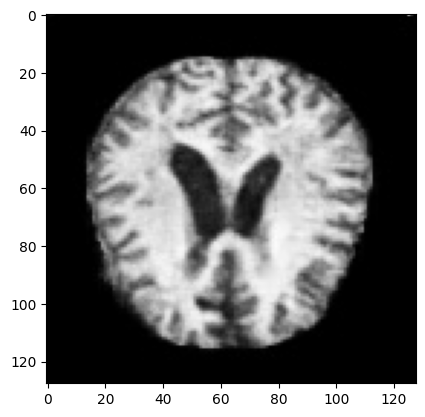

In [ ]:
temp_dir = data_dir + "/Moderate Impairment"

import matplotlib.pyplot as plt

for img in os.listdir(temp_dir):
    img_array = cv2.imread(os.path.join(temp_dir, img))
    #print(img_array)
    plt.imshow(img_array)
    plt.show()
    break

In [ ]:
print(img_array.shape)

(128, 128, 3)


In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.8, 1.2], zoom_range=[0.99, 1.01], horizontal_flip=True, fill_mode="constant", data_format="channels_last")

In [ ]:
train_data_gen = image_generator.flow_from_directory(directory=data_dir, target_size=(176, 176), batch_size=6500, shuffle=True)

Found 10240 images belonging to 4 classes.


In [ ]:
classes = ['Very Mild Impairment', 'No Impairment', 'Mild Impairment', 'Moderate Impairment']

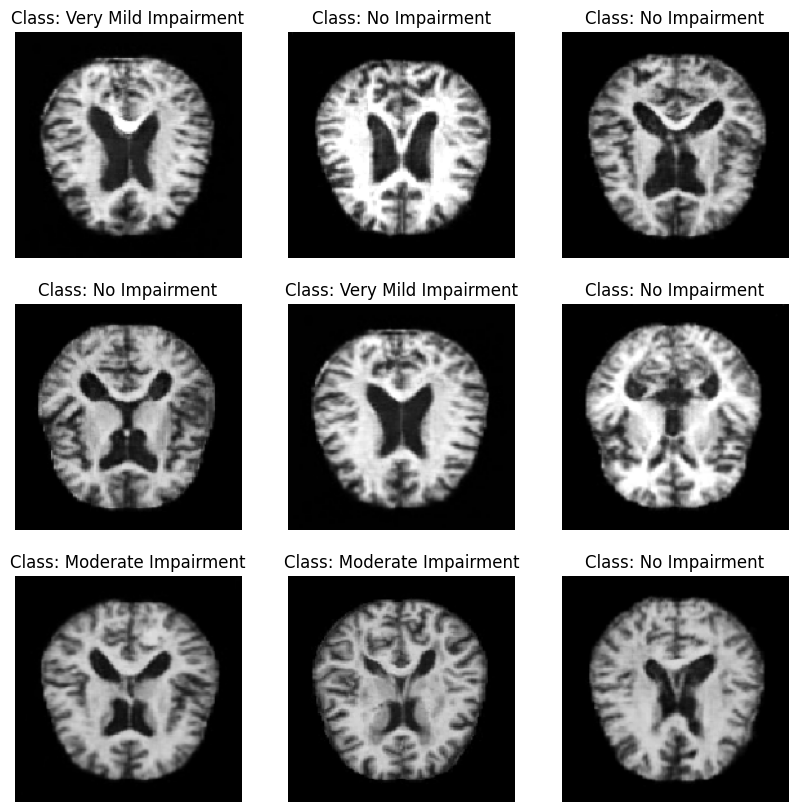

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

def show_images(generator, y_pred=None):
    # Input: An image generator, predicted labels (optional)
    # Output: Displays a grid of 9 random images with labels

    # Define the class names (assuming classes is a predefined list of class names)
    classes = ['Very Mild Impairment', 'No Impairment', 'Mild Impairment', 'Moderate Impairment']  # Update this to your actual classes
    labels = dict(zip([0, 1, 2, 3], classes))

    # Get a batch of images
    x, y = next(generator)

    # Display a grid of 9 images
    plt.figure(figsize=(10, 10))

    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, len(x) - 1)  # Use the length of the batch
            plt.imshow(x[idx].astype('uint8'))
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i].astype('uint8'))
            plt.axis("off")
            plt.title("Actual: {} \nPredicted: {}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))

    plt.show()  # To actually display the plot

# Assuming train_data_gen is your image data generator
show_images(train_data_gen)

In [ ]:
train_data, train_labels = next(train_data_gen)
print(train_data.shape, train_labels.shape)

(3740, 176, 176, 3) (3740, 4)


In [ ]:
for alzheimers_class in classes:
    container = []
    temp_dir = data_dir + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

Very Mild Impairment :  2560
No Impairment :  2560
Mild Impairment :  2560
Moderate Impairment :  2560


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(176, 176, 3)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.3)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.3)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.3)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.3)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder (Upsampling path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.3)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.3)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.3)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.3)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.GlobalAveragePooling2D()(c9)  # Pool to get a single feature vector
    outputs = layers.Dense(4, activation='softmax')(outputs)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 176, 176, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 176, 176, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 176, 176, 64)         36928     ['dropout[0][0]']             
                                                                                              

In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

def extract_features(model, images):


  for layer in reversed(model.layers):
      if isinstance(layer, layers.Conv2D):
          feature_layer = layer
          break

  feature_extractor = models.Model(inputs=model.inputs, outputs=feature_layer.output)

  # Extract features from the specified layer
  features = feature_extractor.predict(images)

  # Reshape features for further processing (e.g., classification)
  features = features.reshape(features.shape[0], -1)

  return features

def unet_model(input_size=(176, 176, 3)):
    inputs = layers.Input(input_size) # Define inputs here to be in the local scope of the function

    # Encoder (Downsampling path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
# Decoder (Upsampling path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),  # Use CategoricalCrossentropy
              metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 176, 176, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 176, 176, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 176, 176, 64)         36928     ['dropout[0][0]']             
                                                                                              

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras_tuner import HyperModel
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(176, 176, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # You can increase this to try more hyperparameter combinations
    executions_per_trial=3,
    directory='data_dir',
    project_name='helloworld'
)


In [ ]:
early_stopping = EarlyStopping(monitor='val_acc', patience=35, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', patience=35, factor=0.1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', save_best_only=True)


# Fit the model
history = model.fit(
    train_data, train_labels,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 10.9811 - acc: 0.2550 - auc: 0.4985

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 174s 1s/step - loss: 10.9811 - acc: 0.2550 - auc: 0.4985 - val_loss: 1.4348 - val_acc: 0.2420 - val_auc: 0.5003 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 93s 992ms/step - loss: 1.3955 - acc: 0.2537 - auc: 0.5140 - val_loss: 1.4359 - val_acc: 0.2420 - val_auc: 0.5208 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - 88s 937ms/step - loss: 1.3770 - acc: 0.2945 - auc: 0.5564 - val_loss: 1.4286 - val_acc: 0.2420 - val_auc: 0.5423 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - 90s 960ms/step - loss: 1.3567 - acc: 0.3098 - auc: 0.5881 - val_loss: 1.4534 - val_acc: 0.3302 - val_auc: 0.5895 - lr: 0.0010
Epoch 5/20
94/94 [==============================] - 95s 1s/step - loss: 1.2408 - acc: 0.4034 - auc: 0.6882 - val_loss: 1.2727 - val_acc: 0.4251 - val_auc: 0.6990 - lr: 0.0010
Epoch 6/20
94/94 [==============================] - 93s 989ms/step - loss: 1.7494 - acc: 0.3977 - auc: 0.6786 - val_loss: 1.3

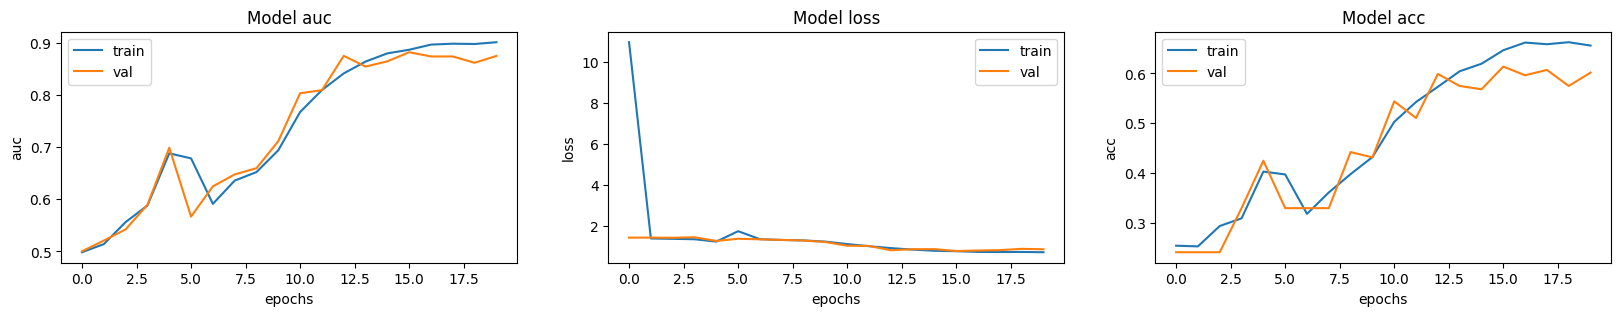

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss', 'acc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_scores = model.evaluate(test_data, test_labels)
test_scores

19/19 [==============================] - 4s 201ms/step - loss: 1.1752 - acc: 0.4433 - auc: 0.7450


[1.1751551628112793, 0.44333332777023315, 0.7449990510940552]

In [ ]:
test_data, test_labels = test_data_gen.next()
print(test_data.shape, test_labels.shape)

(600, 176, 176, 3) (600, 4)


In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.8, 1.2], zoom_range=[0.99, 1.01], horizontal_flip=True, fill_mode="constant", data_format="channels_last")


In [ ]:
test_data_gen = image_generator.flow_from_directory(directory=data_dir, target_size=(176, 176), batch_size=600, shuffle=False)


Found 1279 images belonging to 4 classes.


In [ ]:
predicted_test_labels = model.predict(test_data)

19/19 [==============================] - 4s 207ms/step


In [ ]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in predicted_test_labels:
    labels = roundoff(labels)

In [ ]:
import sklearn

print(sklearn.metrics.classification_report(test_labels, predicted_test_labels, target_names=classes))

                      precision    recall  f1-score   support

Very Mild Impairment       0.29      0.45      0.35       179
       No Impairment       0.03      0.25      0.05        12
     Mild Impairment       0.62      0.02      0.05       409
 Moderate Impairment       0.00      0.00      0.00         0

           micro avg       0.15      0.15      0.15       600
           macro avg       0.24      0.18      0.11       600
        weighted avg       0.51      0.15      0.14       600
         samples avg       0.15      0.15      0.15       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


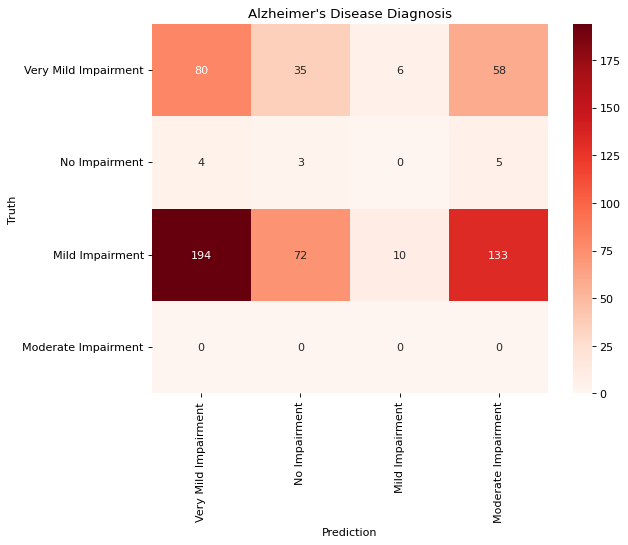

In [ ]:
pred_ls = np.argmax(predicted_test_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = sklearn.metrics.confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

import seaborn as sns
ax = sns.heatmap(conf_arr, cmap='Reds', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(img_array.shape), print(labels.shape)

(128, 128, 3)
(4,)


(None, None)